# Debugging retrofitting code

We're trying to figure out why our results from retrofitting on Sampled Quora and fine-tuning on SST-2 and MR aren't showing the same gains that are in the [Retrofitting Paper](https://aclanthology.org/D19-1113.pdf). We've noticed one key difference, in the embedding distances listed in Table 4. 
- Their table shows average L2 distances between shared words as 3.2 for paraphrases and 4.2 for non-paraphrases before retrofitting, and 1.3 for paraphrases and 5.5 for non-paraphrases (after retrofitting on all three datasets). 
- Our experiments ([example run](https://wandb.ai/jack-morris/rf-bert/runs/eqa5zall?workspace=user-jxmorris12)) show embedding distances of 6.5 for paraphrases and 10.5 for non-paraphrases, both of which are greatly increasing throughout training. Why is this the case? 

## This notebook
In this notebook I want to:
1. Figure out how to get the 3.2 and 4.2 numbers on Quora. We should be able to reproduce this exactly using the pre-trained ELMO model.
2. Diagnose why these numbers are miscomputed in our setup. Are we getting the wrong representations? Or are we feeding in the wrong input? Or are we getting the words at the wrong index somehow?

# Computing L2 distances of base ELMO between words from Quora

## Using our code

In [16]:
# Pretend we're in the root folder of this project ('retrofitting/')
import sys 
sys.path.append('..')

# 1. Get a batch of examples from Quora with shared words, etc.
from dataloaders import ParaphraseDatasetElmo

dataset = ParaphraseDatasetElmo(
    'quora',
    model_name='elmo', num_examples=1024, 
    max_length=40, stop_words_file=f'../stop_words_en.txt',
    r1=0.5, seed=42, split='train'
)

from dataloaders.helpers import train_test_split
train_dataloader, test_dataloader = train_test_split(
    dataset, batch_size=256, 
    shuffle=True, drop_last=True, 
    train_split=0.8
)

Using custom data configuration default
Reusing dataset quora (/home/jxm3/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04/cache-2d905bd4aa27bedf.arrow
Processing quora paraphrases from train split:   0%|          | 1210/404290 [00:01<06:17, 1066.70it/s]


In [20]:
import torch
from models import ElmoRetrofit

# 2. Load batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = tuple(t.to(device) for t in next(iter(train_dataloader)))

# 3. Load ELMO
model = ElmoRetrofit(
    num_output_representations = 1, 
    requires_grad=False,
    elmo_dropout=0,
).to(device)


In [23]:
# 4. Do inference
word_rep_pos_1, word_rep_pos_2, word_rep_neg_1, word_rep_neg_2 = (
            model(*batch)
)

word_rep_pos_1.shape, word_rep_pos_2.shape, word_rep_neg_1.shape, word_rep_neg_2.shape

(torch.Size([256, 1024]),
 torch.Size([256, 1024]),
 torch.Size([256, 1024]),
 torch.Size([256, 1024]))

In [ ]:
def l2norm(t1: torch.Tensor, t2: torch.Tensor):
    (t1 - t2).mean(1)

In [38]:
torch.norm(word_rep_pos_1 - word_rep_pos_2, p=2, dim=1)

tensor([12.0903, 11.9857,  4.4868, 11.6699,  2.0959, 10.3926,  6.0436, 12.3582,
         8.0479,  7.8047,  3.0164,  6.1769, 13.5050, 10.5956,  6.0174, 12.9105,
         7.4838,  9.4541,  8.4242,  6.7361, 14.9254,  9.7438, 10.2964,  8.6891,
         7.2909,  9.8680,  6.3273,  7.4691, 11.6232,  9.3006,  8.7581,  2.9304,
         2.0199,  7.1777,  5.6352,  7.0379,  4.8691, 11.9118,  9.8337, 11.8965,
        15.3541,  7.8360,  4.3216,  4.0533,  7.3775,  4.6901, 14.7758,  5.5396,
         6.5728,  2.6704,  3.4293,  3.5504,  5.2220,  0.5899,  7.3558,  5.0385,
         5.5747,  6.6362,  1.6621,  2.6443,  3.1779,  6.2965,  5.7336,  8.6673,
         4.4809, 11.2629,  1.1161,  8.8685,  3.0433,  9.4950,  3.0517,  1.8758,
         4.4690,  4.1822,  0.7343,  2.9548,  8.2923,  6.6806,  4.3832,  7.5175,
         1.2673,  9.3551,  6.5259,  7.7451,  4.8253,  4.6596,  7.5497,  6.4654,
         3.6612,  4.0151,  2.8291, 10.1500,  2.2860,  6.7031, 10.5323, 11.5086,
         6.7557,  3.2534, 10.3592,  5.54

In [39]:
torch.norm(word_rep_pos_1 - word_rep_pos_2, p=2, dim=1).mean()

tensor(6.9159, device='cuda:0', grad_fn=<MeanBackward0>)

In [40]:
torch.norm(word_rep_neg_1 - word_rep_neg_2, p=2, dim=1).mean()

tensor(11.3434, device='cuda:0', grad_fn=<MeanBackward0>)

Ok, the distances with our code look like the ones in W&B (7 and 11) instead of the ones from the paper (3 and 4ish). I'm going to strip this down to just strings and the pytorch ELMO model and build back up, since I'm not sure where things are going wrong.

## Trying with original code

In [1]:
from typing import List, Tuple, Set
import numpy as np

def get_stop_words(filename: str) -> Set[int]:
    """
    Generates a set of token_ids given a text file of stopwords.
    """

    stop_words = np.genfromtxt(filename, dtype='str')
    return set(stop_words.tolist())

sw = get_stop_words('../stop_words_en.txt')

In [2]:
from mosestokenizer import MosesTokenizer

tokenizer = MosesTokenizer('en', no_escape=True)

def get_shared_word(q1: List[str], q2: List[str]) -> str:
    """gets a shared word that's not a stopword.
    
    takes list of tokens as input
    
    raises StopIteration when no shared words found
    """
    w1 = set([w for w in q1 if w.lower() not in sw])
    w2 = set([w for w in q2 if w.lower() not in sw])
    # print(w1, '//', w2)
    shared_words = w1.intersection(w2)
    return next(iter(shared_words))

In [3]:
import torch
from allennlp.modules.elmo import Elmo

# ELMO 1B, 96m
# options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
# weights_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ELMO 5.5B, 96m
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway_5.5B/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json"
weights_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway_5.5B/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5"

elmo_model = Elmo(options_file=options_file, weight_file=weights_file,
                         num_output_representations=1,
                         requires_grad=True, dropout=0.5,
                         scalar_mix_parameters=[1, 1, 1]).to(device)

elmo_model.eval()
# for param_name, param in elmo_model.named_parameters():
# print(param_name, param.requires_grad)

Elmo(
  (_elmo_lstm): _ElmoBiLm(
    (_token_embedder): _ElmoCharacterEncoder(
      (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
      (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
      (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
      (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
      (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
      (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
      (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
      (_highways): Highway(
        (_layers): ModuleList(
          (0): Linear(in_features=2048, out_features=4096, bias=True)
          (1): Linear(in_features=2048, out_features=4096, bias=True)
        )
      )
      (_projection): Linear(in_features=2048, out_features=512, bias=True)
    )
    (_elmo_lstm): ElmoLstm(
      (forward_layer_0): LstmCellWithProjection(
        (input_linearity): Linear(in_features=512, out_features=16384, b

In [4]:
from allennlp.modules.elmo import batch_to_ids
import pandas as pd
import torch

def batched_inference(model: torch.nn.Module, data: torch.Tensor, batch_size: int=256) -> torch.Tensor:
    i = 0
    output = []
    while i < len(data):
        data_batch = data[i:i+batch_size].to(device)
        i += batch_size
        output.append(model(data_batch)['elmo_representations'][0].cpu())
    return torch.cat(output, dim=0)

def get_shared_word_reps(paraphrases, lower=False) -> Tuple[torch.Tensor, torch.Tensor]:
    paraphrases_and_words = []
    for ex in paraphrases:
        q1 = ex['questions']['text'][0]
        q2 = ex['questions']['text'][1]
        if lower:
            q1 = q1.lower()
            q2 = q2.lower()
        q1 = tokenizer(q1)
        q2 = tokenizer(q2)
        try:
            shared_word = get_shared_word(q1, q2)
            i1 = q1.index(shared_word)
            i2 = q2.index(shared_word)
            paraphrases_and_words.append( (q1, q2, shared_word, i1, i2) )
        except StopIteration:
            continue
    p_df = pd.DataFrame(paraphrases_and_words, columns=['q1_tokens', 'q2_tokens', 'shared_word', 'i1', 'i2'])
    p_df.head()
    # paraphrase IDs
    p_q1_ids = batch_to_ids(p_df['q1_tokens'])
    p_q2_ids = batch_to_ids(p_df['q2_tokens'])
    # using jack scudder's trick here. should be a way to do it with torch.select() though?
    B_p = torch.arange(len(p_q1_ids))
    p_q1_shared_word_ids = p_q1_ids[B_p, p_df['i1']]
    p_q2_shared_word_ids = p_q2_ids[B_p, p_df['i2']]
    # make sure shared word indices are the same - this should print True!
    print(torch.all(p_q1_shared_word_ids == p_q2_shared_word_ids, 0).all())
    with torch.no_grad():
        # print(q1_reps.keys()) # dict_keys(['elmo_representations', 'mask'])
        # print(len(q1_reps['elmo_representations'])) # list of length 1
        # print(q1_reps['elmo_representations'][0].shape) # [727, 33, 1024]
        B = torch.arange(len(p_q1_ids))
        p_q1_reps = batched_inference(elmo_model, p_q1_ids)
        p_q1_shared_word_reps = p_q1_reps[B, p_df['i1']] # [727, 1024]
        p_q2_reps = batched_inference(elmo_model, p_q2_ids)
        p_q2_shared_word_reps = p_q2_reps[B, p_df['i2']]
    return p_q1_shared_word_reps, p_q2_shared_word_reps

In [5]:
import datasets
d = datasets.load_dataset('quora')['train']
d = datasets.Dataset.from_dict(d[:8_000])
quora_paraphrases = d.filter(lambda ex: ex['is_duplicate'])
quora_non_paraphrases = d.filter(lambda ex: not ex['is_duplicate'])

len(quora_paraphrases), len(quora_non_paraphrases)

Using custom data configuration default
Reusing dataset quora (/home/jxm3/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

(18649, 31351)

In [6]:
q_p1, q_p2 = get_shared_word_reps(quora_paraphrases, lower=False)
# I want this to be 3.17
# ELMO 5.5B:
# - with uppercase letters included (lower=False): 4.122    
# - without uppercase letters: 3.808
# ELMO 1B:
# - with uppercase letters included (lower=False): 6.737
# - without uppercase letters: 6.463
(q_p1 - q_p2).norm(p=2, dim=1).mean() 

tensor(True)


tensor(4.1280)

In [ ]:
q_n1, q_n2 = get_shared_word_reps(quora_non_paraphrases, lower=False)
# I want this to be 4.42
# ELMO 5.5B:
# - with uppercase letters included: 
# - without uppercase letters: 
# ELMO 1B:
# - with uppercase letters included: 
# - without uppercase letters: 
(q_n1 - q_n2).norm(p=2, dim=1).mean() 

tensor(True)


<AxesSubplot:>

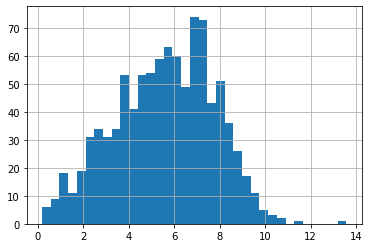

In [21]:
pd.Series((q_n1 - q_n2).norm(p=2, dim=1).cpu()).hist(bins=35)